In [1]:
import numpy as np
import matplotlib.pyplot as plt
import toast.qarray as qa
import healpy as hp
from scipy.spatial.transform import Rotation as R
import ephem
from simons_array_python.calibration.planet import ephem_planet
from skyfield import api

INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_runid.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_runid_g3.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_data_quality.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_mapping.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_monitor.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_stim_template.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_stim_iq.db attached.
INFO: numpy.fft used.


/opt/pkgs/spt3g_software_sa_2019-05-13/build/spt3g/gcp/ARCExtractor.py:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if uname is not 'None':


In [2]:
def get_boresight_quat(input_az, input_el):
    azel_quat = qa.from_angles(
        np.pi/2 - input_el,
        -1.*input_az,
        0,
    )
    r_azel_quat = R.from_quat(azel_quat)

    xra, xdec = observer.radec_of(0, 0)
    yra, ydec = observer.radec_of(-np.pi/2, 0)
    zra, zdec = observer.radec_of(0, np.pi/2)

    # chain1 = radec_sampling(0, 0, observer, niter=100000)
    # chain2 = radec_sampling(-np.pi/2, 0, observer, niter=100000)
    # chain3 = radec_sampling(0, np.pi/2, observer, niter=100000)

    # xra, xdec = chain1[-1][0:2]
    # yra, ydec = chain2[-1][0:2]
    # zra, zdec = chain3[-1][0:2]

    # print(chain1[-1][2], chain2[-1][2], chain3[-1][2])

    xvec, yvec, zvec = hp.ang2vec(np.pi/2 - np.array([xdec, ydec, zdec]),
                               np.array([xra, yra, zra]))

    xvec /= np.sqrt(np.dot(xvec, xvec))
    yvec -= np.dot(xvec, yvec) * xvec
    yvec /= np.sqrt(np.dot(yvec, yvec))
    zvec -= np.dot(xvec, zvec) * xvec + np.dot(yvec, zvec) * yvec
    zvec /= np.sqrt(np.dot(zvec, zvec))

    # Solve for the quaternions from the transformed axes.
    X = (xvec[1] + yvec[0]) / 4
    Y = (xvec[2] + zvec[0]) / 4
    Z = (yvec[2] + zvec[1]) / 4

    d = np.sqrt(np.abs(Y * Z / X)) # Choose positive root
    c = d * X / Y
    b = X / c
    a = (xvec[1]/2 - b*c) / d

    # qarray has the scalar part as the last index
    conversion_quat = qa.norm(np.array([b, c, d, a]))
    # boresight_quat = qa.mult(conversion_quat, azel_quat)
    # theta, phi, p = qa.to_angles(boresight_quat)

    r_conversion_quat = R.from_quat(conversion_quat)
    r_boresight = r_conversion_quat * r_azel_quat
    return r_boresight

In [4]:
def radec_to_azel(ra, dec, observer):
    obj = ephem.FixedBody()
    obj._ra = ra
    obj._dec = dec
    obj._epoch = observer.epoch
    obj.compute(observer)
    az, el = obj.az, obj.alt
    return az, el

In [4]:
def get_other_radec(ra, dec, observer):
    obj = ephem.FixedBody()
    obj._ra = ra
    obj._dec = dec
    obj._epoch = observer.epoch
    obj.compute(observer)
    ra, dec = obj.ra, obj.dec
    return ra, dec

In [5]:
def get_error_angles(ra1, dec1, ra2, dec2):
    
    return np.arccos(np.dot(hp.ang2vec(np.pi/2-dec1, ra1), hp.ang2vec(np.pi/2-dec2, ra2)))

In [6]:
def radec_sampling(target_az, target_el, observer, niter=100):
    ra_init, dec_init = observer.radec_of(target_az, target_el)
    error = get_error_azel(ra_init, dec_init, target_az, target_el, observer)
    chain = np.zeros((niter, 3))
    chain[0] = np.array([ra_init, dec_init, error])
    
    for i in range(1, niter):
        ra = chain[i-1][0] + np.random.normal(0, 1e-4)
        dec = chain[i-1][1] + np.random.normal(0, 1e-4)

        error = get_error_azel(ra, dec, target_az, target_el, observer)
        if error < chain[i-1][2]:
            chain[i] = np.array([ra, dec, error])
        else:
            chain[i] = chain[i-1]
        
    return chain

In [2]:
observer = ephem_planet.pb2a_site()
observer.pressure=0
observer.date=44000
# observer.epoch=ephem.J2000
z = np.array([0,0,1])
observer

<ephem.Observer date='2020/6/19 12:00:00' epoch='2000/1/1 12:00:00' lon='-67:47:10.6' lat='-22:57:28.5' elevation=5156.0m horizon=0:00:00.0 temp=15.0C pressure=0.0mBar>

In [60]:
el = 20 * np.pi/180

In [61]:
ra1, dec1 = observer.radec_of(0,el)

In [62]:
observer.pressure=0
ra2, dec2 = observer.radec_of(0,el)

In [63]:
np.sqrt((ra1-ra2)**2 + (dec1-dec2)**2) * 180/np.pi * 60 * 60

156.7945712351284

In [8]:
observer.lat

-0.40069104906336134

In [26]:
observer.lon * 180/np.pi

-67.78628

In [27]:
obj = ephem.FixedBody()
obj._ra = 1
obj._dec = 1
obj._epoch = observer.epoch
obj.compute(observer)

In [3]:
obj.alt

NameError: name 'obj' is not defined

In [29]:
obj.g_ra

1.0069132061741284

In [30]:
obj.ra

1.0069132061741284

(17.204585153068233, 0.18260072120089926)

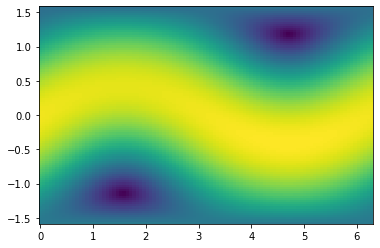

In [31]:
#sweep over ra/dec to see the size of the effect
ra_sweep = np.linspace(0, 2*np.pi, 100)
dec_sweep = np.linspace(-np.pi/2+1e-6, np.pi/2-1e-6, 100)

errors = np.zeros((len(ra_sweep), len(dec_sweep)))
for i, ra in enumerate(ra_sweep):
    for j, dec in enumerate(dec_sweep):
        ra1, dec1 = get_other_radec(ra, dec, observer)
        errors[j][i] = get_error_angles(ra, dec, ra1, dec1)
        
X, Y = np.meshgrid(ra_sweep, dec_sweep)
plt.pcolormesh(X, Y, errors)
np.nanmax(errors) * 180/np.pi * 60 , np.nanmin(errors) * 180/np.pi * 60 

In [5]:
#sweep over azel
az_sweep = np.linspace(0, 2*np.pi, 100)
el_sweep = np.linspace(-np.pi/2+1e-6, np.pi/2-1e-6, 100)

errors = np.zeros((len(az_sweep), len(el_sweep)))
for i, az in enumerate(az_sweep):
    for j, el in enumerate(el_sweep):
        ra, dec = observer.radec_of(az, el)
#         other_ra, other_dec = get_other_radec(ra, dec, observer)
        other_az, other_el = radec_to_azel(other_ra, other_dec, observer)
        errors[j][i] = get_error_angles(az, el, other_az, other_el)
        
X, Y = np.meshgrid(az_sweep, el_sweep)
plt.pcolormesh(X, Y, errors)
np.nanmax(errors) * 180/np.pi * 60 , np.nanmin(errors) * 180/np.pi * 60 

NameError: name 'other_ra' is not defined

(0.7704335568015129, 0.004995823497757312)

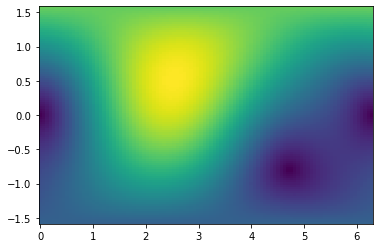

In [33]:
#sweep over az/el to see the size of the effect
az_sweep = np.linspace(1e-6, 2*np.pi, 100)
el_sweep = np.linspace(-np.pi/2+1e-6, np.pi/2-1e-6, 100)

errors = np.zeros((len(az_sweep), len(el_sweep)))
for i, az in enumerate(az_sweep):
    for j, el in enumerate(el_sweep):
        boresight = get_boresight_quat(az, el, observer)
        v1 = boresight.apply(z)
        ra, dec = observer.radec_of(az, el)
#         ra, dec = get_other_radec(ra, dec, observer)
        v2 = hp.ang2vec(np.pi/2-dec, ra)
        errors[j][i] = np.arccos(np.dot(v1, v2))
        
X, Y = np.meshgrid(az_sweep, el_sweep)
plt.pcolormesh(X, Y, errors)

np.nanmax(errors) * 180/np.pi * 60 , np.nanmin(errors) * 180/np.pi * 60